In [14]:
pip install -U scikit-image

  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
   ---------------------------------------- 0.0/25.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/25.0 MB 2.4 MB/s eta 0:00:11
    --------------------------------------- 0.4/25.0 MB 4.9 MB/s eta 0:00:06
   - -------------------------------------- 0.6/25.0 MB 5.1 MB/s eta 0:00:05
   - -------------------------------------- 0.8/25.0 MB 5.4 MB/s eta 0:00:05
   -- ------------------------------------- 1.4/25.0 MB 6.0 MB/s eta 0:00:04
   -- ------------------------------------- 1.7/25.0 MB 6.5 MB/s eta 0:00:04
   -- ------------------------------------- 1.8/25.0 MB 5.8 MB/s eta 0:00:05
   --- ------------------------------------ 2.2/25.0 MB 6.0 MB/s eta 0:00:04
   --- ------------------------------------ 2.4/25.0 MB 5.8 MB/s eta 0:00:04
   ---- ----------------------------------- 2.6/25.0 MB 5.6 MB/s eta 0:00:04
   ---- ----------------------------------- 2.7/25.0 MB 5.4 MB/s eta 0:00:05
   ---- ----------

In [3]:
import math
import time

import cv2
import numpy as np
img = cv2.imread('clip_LC09_L2SP_138045_20221114_20230322_02_T1_SR_B5.tif')
img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img)

[[61 65 65 ... 30 30 29]
 [65 66 66 ... 31 30 30]
 [68 67 67 ... 31 30 30]
 ...
 [51 51 49 ... 27 27 28]
 [47 47 48 ... 28 27 27]
 [53 51 50 ... 28 27 27]]


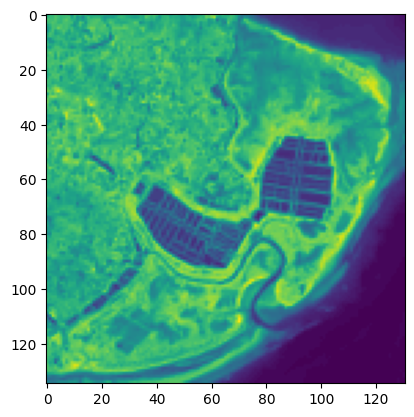

In [4]:
import matplotlib.pyplot as plt
plt.imshow(img)
#plt.savefig('D:\ML Proj\Multilevel thresholding\Segmented Saptamukhi & RoI\Saptamukhi Grayscale Band 3',bbox_inches='tight')
plt.show()

In [5]:
a = 0
b = 255
n = 6 # number of thresholds (better choose even value)
k = 0.7 # free variable to take any positive value
T = [] # list which will contain 'n' threshold
start=time.time()
def multiThresh(img, a, b):
    if a>b:
        s=-1
        m=-1
        return m,s

    img = np.array(img)
    t1 = (img>=a)
    t2 = (img<=b)
    X = np.multiply(t1,t2)
    Y = np.multiply(img,X)
    s = np.sum(X)
    m = np.sum(Y)/s
    return m,s

for i in range(int(n/2-1)):
    img = np.array(img)
    t1 = (img>=a)
    t2 = (img<=b)
    X = np.multiply(t1,t2)
    Y = np.multiply(img,X)
    mu = np.sum(Y)/np.sum(X)

    Z = Y - mu
    Z = np.multiply(Z,X)
    W = np.multiply(Z,Z)
    sigma = math.sqrt(np.sum(W)/np.sum(X))

    T1 = mu - k*sigma
    T2 = mu + k*sigma

    x, y = multiThresh(img, a, T1)
    w, z = multiThresh(img, T2, b)

    T.append(x)
    T.append(w)

    a = T1+1
    b = T2-1
    k = k*(i+1)

T1 = mu
T2 = mu+1
x, y = multiThresh(img, a, T1)
w, z = multiThresh(img, T2, b)    
T.append(x)
T.append(w)
T.sort()
print(T)
end=time.time()
print(end-start)

[33.92254528122021, 52.44374672946102, 58.5451467268623, 61.0, 64.05557670346403, 70.3435278914495]
0.0019919872283935547


In [6]:
regions = np.digitize(img, bins=T)
regions.shape

(135, 131)

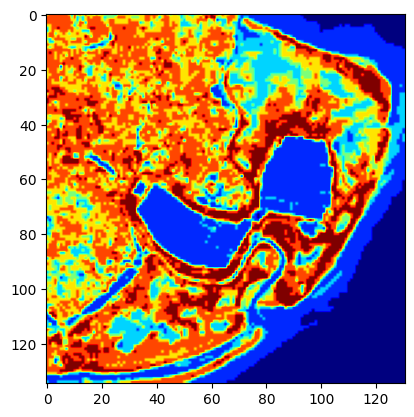

In [7]:
import matplotlib.pyplot as plt
plt.imshow(regions, cmap='jet')
#plt.savefig('D:\ML Proj\Multilevel thresholding\Segmented Saptamukhi & RoI\Band3_T=2_k=0.7.png',bbox_inches='tight')
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(img,regions)

In [11]:
print(mse)

2993.365055131467


In [12]:
s=255
#peak signal to noise ratio (PSNR) index
psnr=10*math.log((s**n)/mse)
print("PSNR in dB: ",psnr)

PSNR in dB:  252.434278008959


In [16]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops

# Assume that the Landsat image has been segmented using multilevel thresholding 
# and the resulting segmented regions are stored in a variable called 'labels'
labels=regions
# Define the number of gray levels and distance offset for GLCM analysis
gray_levels = 255
distances = [1, 2, 3]

# Initialize arrays to store texture features for each segmented region
contrast = np.zeros(len(np.unique(labels)))
homogeneity = np.zeros(len(np.unique(labels)))
energy = np.zeros(len(np.unique(labels)))
correlation = np.zeros(len(np.unique(labels)))

# Loop through each segmented region and calculate texture features
for i, label in enumerate(np.unique(labels)):
    region = (labels == label)  # Extract binary mask for current region
    glcm = graycomatrix(region.astype(np.uint8) * (gray_levels-1), distances, [0, np.pi/4, np.pi/2, 3*np.pi/4], gray_levels, symmetric=True, normed=True)
    contrast[i] = graycoprops(glcm, 'contrast').mean()
    homogeneity[i] = graycoprops(glcm, 'homogeneity').mean()
    energy[i] = graycoprops(glcm, 'energy').mean()
    correlation[i] = graycoprops(glcm, 'correlation').mean()

# Print the mean texture features for all segmented regions
print("Mean Contrast:", contrast.mean())
print("Mean Homogeneity:", homogeneity.mean())
print("Mean Energy:", energy.mean())
print("Mean Correlation:", correlation.mean())


Mean Contrast: 8493.446572206498
Mean Homogeneity: 0.8683533553605018
Mean Energy: 0.8053877993861992
Mean Correlation: 0.42996291418481813
